In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import custom_resnet
from lucent.misc.io.showing import animate_sequence

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(skip_batchnorm=True).to(device).eval()

100%|██████████| 512/512 [00:10<00:00, 51.07it/s]



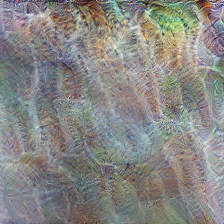
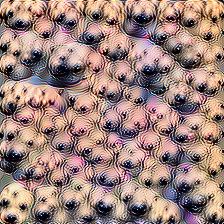

In [ ]:
param_f = lambda: param.image(224, batch=2)
obj = objectives.channel("layer3", 255, batch=1) - objectives.channel("layer3", 255, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:07<00:00, 64.91it/s]



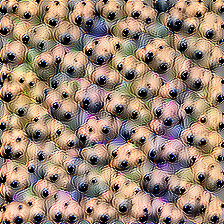

In [ ]:
param_f = lambda: param.image(224)
obj = objectives.channel("layer3_0_conv2", 255)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:08<00:00, 57.69it/s]



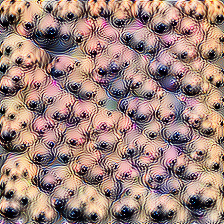
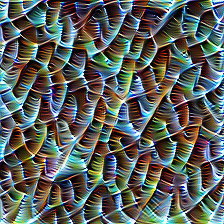

In [ ]:
param_f = lambda: param.image(224, batch=2)
obj = objectives.channel("layer3_1_conv2", 255, batch=0) - objectives.channel("layer3_0_downsample_1", 255, batch=1)
_ = render.render_vis(model, obj, param_f, show_inline=True)

In [ ]:
neuron1 = ('layer3', 255)
neuron2 = ('layer2', 62)

100%|██████████| 512/512 [00:07<00:00, 65.12it/s]



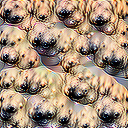
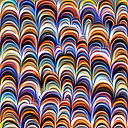
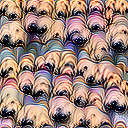

In [ ]:
param_f = lambda: param.image(128, batch=3)

# First image optimizes neuron1
# Second image optimizes neuron2
# Third image optimizes sum of both
C = lambda neuron1, neuron2: objectives.channel(*neuron1, batch=0) + \
  objectives.channel(*neuron2, batch=1) + \
  objectives.channel(*neuron1, batch=2) + \
  objectives.channel(*neuron2, batch=2)

_ = render.render_vis(model, C(neuron1, neuron2), param_f, show_inline=True)

100%|██████████| 512/512 [00:15<00:00, 33.58it/s]



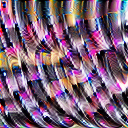
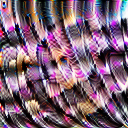
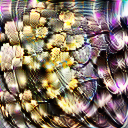
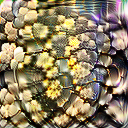
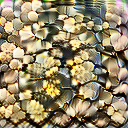
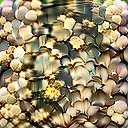

In [ ]:
def interpolate_param_f():
  # We start with a batch of FFT parameterized images
  params, image_f = param.fft_image((6, 3, 128, 128))
  # We then add a bunch of low-res interpolated tensors
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  # Accumulate the params and outputs
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("layer4_0_conv1", 16, "layer4_1_conv2", 18)

sequence = render.render_vis(model, obj, interpolate_param_f, show_inline=True)


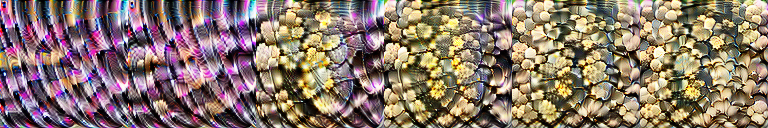

In [ ]:
animate_sequence(sequence[0])

100%|██████████| 512/512 [00:14<00:00, 35.63it/s]



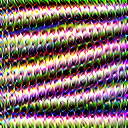
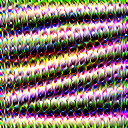
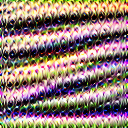
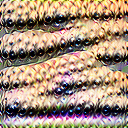
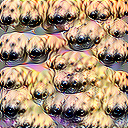
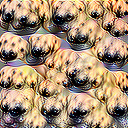

In [ ]:
def interpolate_param_f():
  # We start with a batch of FFT parameterized images
  params, image_f = param.fft_image((6, 3, 128, 128))
  # We then add a bunch of low-res interpolated tensors
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  # Accumulate the params and outputs
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("layer3_0_conv1", 255, "layer3_1_conv2", 255)

sequence = render.render_vis(model, obj, interpolate_param_f, show_inline=True)


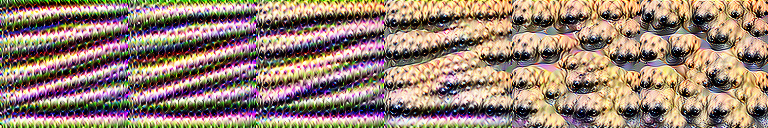

In [ ]:
animate_sequence(sequence[0])

100%|██████████| 512/512 [00:16<00:00, 30.20it/s]



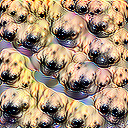
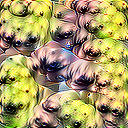
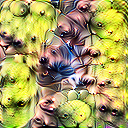
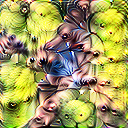
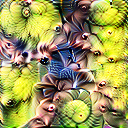
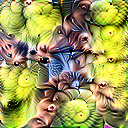

In [ ]:
def interpolate_param_f():
  # We start with a batch of FFT parameterized images
  params, image_f = param.fft_image((6, 3, 128, 128))
  # We then add a bunch of low-res interpolated tensors
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  # Accumulate the params and outputs
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("layer3_1_conv2", 255, "layer4_1_conv2", 221)

sequence = render.render_vis(model, obj, interpolate_param_f, show_inline=True)